# Fundamentals of Software Systems (FSS)
**Software Evolution – Part 02 Assignment**

## Submission Guidelines

To correctly complete this assignment you must:
* Carry out the assignment in a team of 2 to 4 students.
* Carry out the assignment with your team only. You are allowed to discuss solutions with other teams, but each team should come up its own personal solution. A strict plagiarism policy is going to be applied to all the artifacts submitted for evaluation.
* As your submission, upload the filled Jupyter Notebook (including outputs) together with the d3 visualization web pages (i.e. upload everything you downloaded including the filled Jupyter Notebook plus your `output.json`)
* The files must be uploaded to OLAT as a single ZIP (`.zip`) file by Dec 15, 2025 @ 23:55.


## Group Members
* Firstname, Lastname, Immatrikulation Number
* Lucía, Cortés Páez, 24-744-112
* Oliver, Strassmann, 15-932-726

## Task Context

In this assigment we will be analyzing the _elasticsearch_ project. All following tasks should be done with the subset of commits from tag `v1.0.0` to tag `v1.1.0`.

In [3]:
import subprocess
from enum import Enum
from pathlib import Path

import pydriller


class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"

In [ ]:
repo_url = "https://github.com/elastic/elasticsearch"
repo = pydriller.Repository(repo_url, from_tag="v1.0.0", to_tag="v1.1.0")

## Task 1: Author analysis

In the following, please consider only `java` files.

The first task is to get an overview of the author ownership of the _elasticsearch_ project. In particular, we want to understand who are the main authors in the system between the two considered tags, the authors distribution among files and the files distribution among authors. To this aim, perform the following:
- create a dictionary (or a list of tuples) with the pairs author => number of modified files
- create a dictionary (or a list of tuples) with the pairs file => number of authors who modified the file
- visualize the distribution of authors among files: the visualization should have on the x axis the number of authors per file (from 1 to max), and on the y axis the number of files with the given number of authors (so for example the first bar represent the number of files with single author)
- visualize the distribution of files among authors: the visualization should have on the x axis the number of files per author (from 1 to max), and on the y axis the number of authors that own the given number of files (so for example the first bar represent the minor contributors, i.e., the number of authors who own 1 file)

Comment the two distribution visualizations.



Now, let's look at the following 3 packages in more details:
1. `src/main/java/org/elasticsearch/search`
2. `src/main/java/org/elasticsearch/index`
3. `src/main/java/org/elasticsearch/action`

Create a function that, given the path of a package and a modification type (see class Modification above), returns a dictionary of authors => number, where the number counts the total lines added or removed or added+removed or added-removed (depending on the given Modification parameter), for the given package. To compute the value at the package level, you should aggregate the data per file.

Using the function defined above, visualize the author contributions (lines added + lines removed). The visualization should have the author on the x axis, and the total lines on the y axis. Sort the visualization in decreasing amount of contributions, i.e., the main author should be the first.

Compare the visualization for the 3 packages and comment.

git commit count (from_tag..to_tag): 516
unique java files touched: 1020
unique authors touching java files: 45


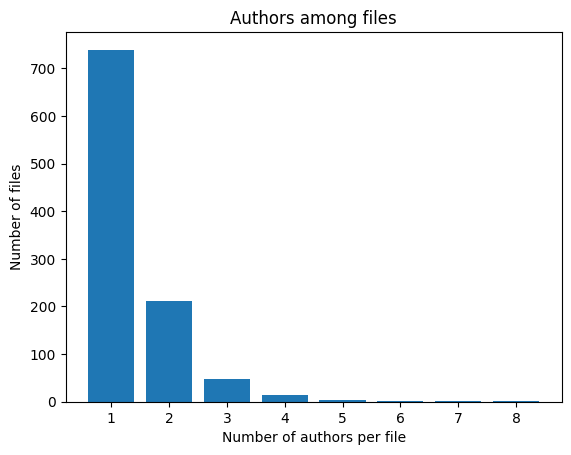

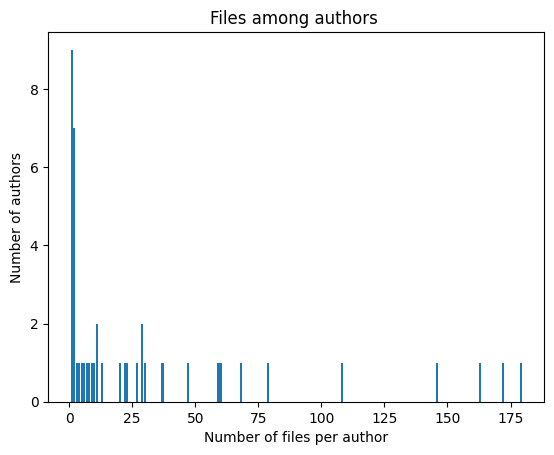

In [1]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from pydriller.git import Git

repo_path = r"C:\Users\lucia\OneDrive\Documentos\Github_Repos\elasticsearch" #local repo path
from_tag = "v1.0.0"
to_tag = "v1.1.0"


git = Git(repo_path) #we use GitPython directly (through PyDriller's Git wrapper) because traverse_commits() keeps returning 0 in our notebook
repo = git.repo 

#we iterate commits in the tag range and collect java file ownership
author_to_files = defaultdict(set)
file_to_authors = defaultdict(set) 

commit_list = list(repo.iter_commits(f"{from_tag}..{to_tag}"))
print("git commit count (from_tag..to_tag):", len(commit_list))

for c in commit_list:
    author = c.author.name if c.author is not None else "Unknown"
    touched_files = list(c.stats.files.keys()) #we use stats.files to get the list of touched files for this commit

    for file_path in touched_files:
        if not file_path.endswith(".java"): #we only consider java files
            continue

        author_to_files[author].add(file_path)
        file_to_authors[file_path].add(author)

print("unique java files touched:", len(file_to_authors))
print("unique authors touching java files:", len(author_to_files))

#we convert sets to counts
author_to_num_files = {author: len(files) for author, files in author_to_files.items()}  # dictionary with the pairs author => number of modified files
file_to_num_authors = {file_path: len(authors) for file_path, authors in file_to_authors.items()} # dictionary with the pairs file => number of authors who modified the file


#visualization 1: distribution of authors among files
authors_per_file = list(file_to_num_authors.values())
authors_per_file_dist = Counter(authors_per_file)

max_authors = max(authors_per_file_dist.keys())
x = list(range(1, max_authors + 1))
y = [authors_per_file_dist.get(k, 0) for k in x]

plt.figure()
plt.bar(x, y)
plt.xlabel("Number of authors per file")
plt.ylabel("Number of files")
plt.title("Authors among files")
plt.show()

#visualization 2: distribution of files among authors
files_per_author = list(author_to_num_files.values())
files_per_author_dist = Counter(files_per_author)

max_files = max(files_per_author_dist.keys())
x = list(range(1, max_files + 1))
y = [files_per_author_dist.get(k, 0) for k in x]

plt.figure()
plt.bar(x, y)
plt.xlabel("Number of files per author")
plt.ylabel("Number of authors")
plt.title("Files among authors ")
plt.show()


### Authors among files

In the first distribution we can see that most Java files are modified by a single author, and the number of files decreases fast as the number of authors per file increases. Files with two authors are still relatively common, but files with three or more authors are rare. This suggests that the project follows a strong file ownership model, where most files have a clear main contributor. The few files touched by many authors are likely core or highly coupled components that require frequent coordination or are more exposed to changes during development.

### Files among authors

In the second image, we can see that the distribution is highly skewed. Most authors modify only a small number of files, which indicates that there are many minor or occasional contributors. In the other hand, a small number of authors modify a very large number of files, forming a long tail on the right side of the distribution. This shows a typical core–periphery structure, where a small group of core developers is responsible for most of the changes across the system, while many other contributors focus on limited and localized modifications.

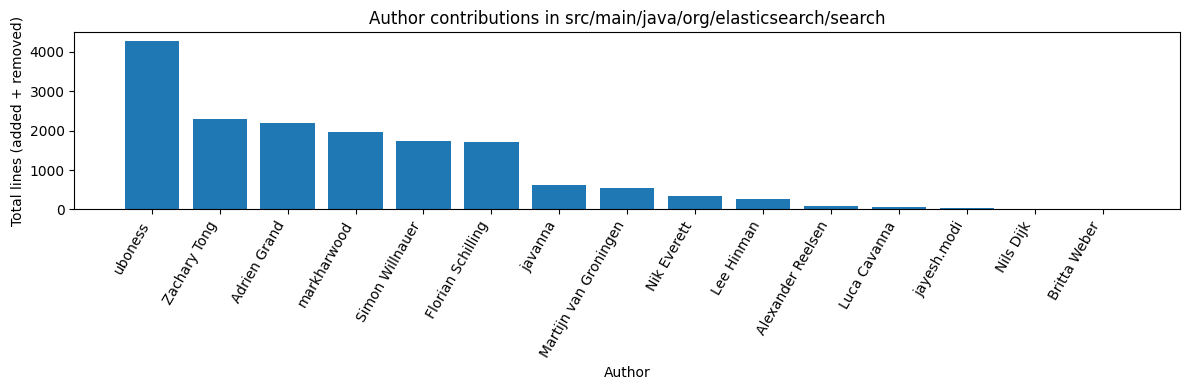

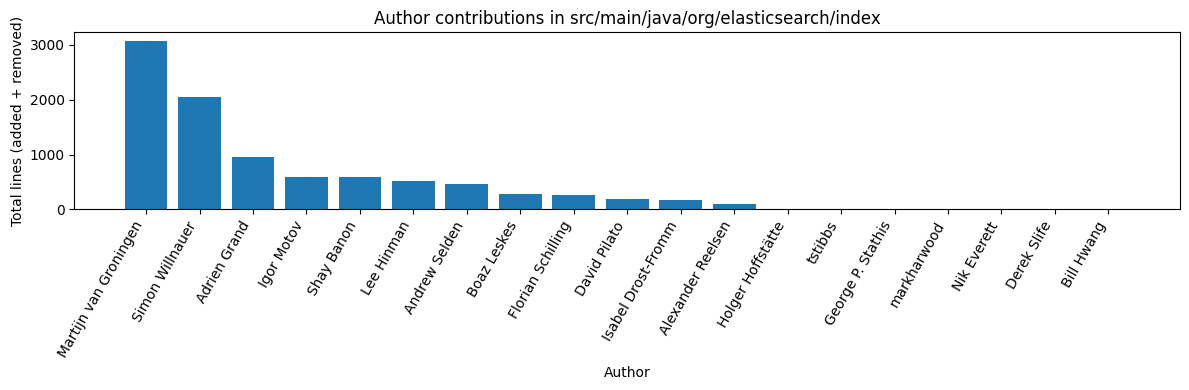

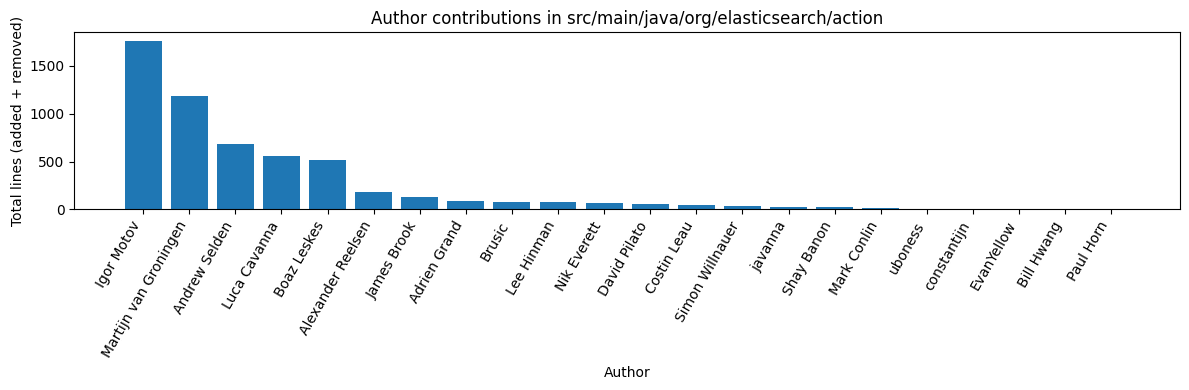

In [4]:
#we define the three packages we want to analyze
packages = [
    "src/main/java/org/elasticsearch/search",
    "src/main/java/org/elasticsearch/index",
    "src/main/java/org/elasticsearch/action",
]

def author_contributions_for_package(package_path: str, mod_type: Modification) -> dict:
    #we aggregate lines per author, but only for files inside the given package
    author_to_lines = defaultdict(int)

    #we iterate the commits between the two tags
    for c in repo.iter_commits(f"{from_tag}..{to_tag}"):
        author = c.author.name if c.author is not None else "Unknown"

        #we compute per-file stats for this commit and then sum them at package level
        for file_path, stats in c.stats.files.items():
            #we only consider java files inside the package folder
            if not file_path.endswith(".java"):
                continue
            if not file_path.startswith(package_path):
                continue

            lines_added = stats.get("insertions", 0)
            lines_removed = stats.get("deletions", 0)

            if mod_type == Modification.ADDED:
                value = lines_added
            elif mod_type == Modification.REMOVED:
                value = lines_removed
            elif mod_type == Modification.TOTAL:
                value = lines_added + lines_removed
            elif mod_type == Modification.DIFF:
                value = lines_added - lines_removed
            else:
                value = 0

            author_to_lines[author] += value

    return dict(author_to_lines)


#we visualize author contributions (lines added + lines removed) for each package
for package_path in packages:
    author_to_total = author_contributions_for_package(package_path, Modification.TOTAL)

    #we sort authors by total contribution (descending)
    sorted_items = sorted(author_to_total.items(), key=lambda x: x[1], reverse=True)
    authors = [a for a, _ in sorted_items]
    totals = [v for _, v in sorted_items]

    plt.figure(figsize=(12, 4))
    plt.bar(authors, totals)
    plt.xlabel("Author")
    plt.ylabel("Total lines (added + removed)")
    plt.title(f"Author contributions in {package_path}")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()

### Comparison of author contributions across the three packages

In all three packages, the distributions show a strongly skewed contribution pattern, where a small number of authors are responsible for most of the changes, while many others contribute only a little.

- org.elasticsearch.index
This package is dominated by a single main contributor, with a very high number of modified lines compared to the rest. After the top author, there is a gradual decrease in contributions, but still a relatively large group of secondary contributors. This can indicate that the index package is actively developed and possibly complex, so it requires frequent modifications by several experienced developers, while still having a clear main maintainer.

- org.elasticsearch.search
The search package shows a slightly more balanced distribution among the top contributors. Although one author still stands out, the gap between the first few authors is smaller than in the index package. This indicates a more shared ownership among core developers, which possibly means that searching functionality is central to the system and requires collaboration and coordinated changes.

- org.elasticsearch.action
The action package presents a more fragmented contribution pattern. While there is still a leading author, the overall number of modified lines is lower, and many authors contribute small amounts. This suggests that the package may consist of more modular or isolated features, which allows occasional or task-specific contributions without a big involvement from a large core team.

## Task 2: Knowledge loss

We now want to analyze the knowledge loss when the main contributor of the analyzed project would leave. For this we will use the circle packaging layout introduced in the "Code as a Crime Scene" book. This assignment includes the necessary `knowledge_loss.html` file as well as the `d3` folder for all dependencies. You task is to create the `output.json` file according to the specification below. This file can then be visualized with the files provided.

For showing the visualization, once you have the output as `output.json` you should
* make sure to have the `knowledge_loss.html` file in the same folder
* start a local HTTP server in the same folder (e.g. with python `python3 -m http.server`) to serve the html file (necessary for d3 to work)
* open the served `knowledge_loss.html` and look at the visualization

For the package you identify as the worst in terms of knowledge loss, investigate the author contributions using the function defined in the previous exercise and comment how the situation is, e.g. how big the gap between the main author and the second biggest contributor for the selected package is.

### Output Format for Visualization

* `root` is always the root of the tree
* `size` should be the total number of lines of contribution
* `weight` can be set to the same as `size`
* `ownership` should be set to the percentage of contributions from the main author (e.g. 0.98 for 98% if contributions coming from the main author)

```
{
  "name": "root",
  "children": [
    {
      "name": "test",
      "children": [
        {
          "name": "benchmarking",
          "children": [
            {
              "author_color": "red",
              "size": "4005",
              "name": "t6726-patmat-analysis.scala",
              "weight": 1.0,
              "ownership": 0.9,
              "children": []
            },
            {
              "author_color": "red",
              "size": "55",
              "name": "TreeSetIterator.scala",
              "weight": 0.88,
              "ownership": 0.9,
              "children": []
            }
          ]
        }
      ]
    }
  ]
}
```

### JSON Export

For exporting the data to JSON you can use the following snippet:
```
import json

with open("output.json", "w") as file:
    json.dump(tree, file, indent=4)
```

In [ ]:
from pathlib import Path

from pydantic import BaseModel
from pydriller.git import Git


class Node(BaseModel):
    name: str
    children: list


class LeafNode(BaseModel):
    name: str
    size: int
    author_color: str
    weight: int
    ownership: float


available_colors = [
    "green",
    "red",
    "black",
    "blue",
    "cyan",
    "grey",
    "magenta",
    "mint",
    "orange",
    "purple",
    "white",
    "yellow",
    "aqua",
    "beige",
    "brown",
    "coral",
    "crimson",
    "darkblue",
    "darkgreen",
    "darkorange",
    "darkpurple",
    "gold",
    "indigo",
    "ivory",
    "khaki",
    "lavender",
    "lime",
    "maroon",
    "navy",
    "olive",
    "peach",
    "periwinkle",
    "plum",
    "salmon",
    "silver",
    "tan",
    "teal",
    "turquoise",
    "violet",
    "wheat",
    "yellowgreen",
    "rose",
    "sienna",
    "slateblue",
    "slategray",
    "mediumseagreen",
    "mediumvioletred",
    "lightsalmon",
    "lightcoral"
]


def _get_new_color_for_author(data: dict) -> str:
    if next_color := next((color for color in available_colors if color not in data.values()), None):
        return next_color

    print("No available colors left for new author, returning default color...")
    return "red"


def _calculate_ownership(author_contributions: dict, total_lines: int) -> float:
    if total_lines == 0:
        return 0
    main_author = max(author_contributions, key=author_contributions.get)
    return author_contributions[main_author] / total_lines


def _update_author_summary(data: dict, file_name: str, author_name: str) -> dict:
    if file_name not in data:
        data[file_name] = {}

    if author_name not in data[file_name]:
        data[file_name][author_name] = 0

    return data


def _create_new_leaf_node(file_path: str, commit, colors_map: dict, author_summary: dict) -> tuple[LeafNode, dict, dict]:
    author_name = commit.author.name
    file_name = file_path.split("/")[-1].replace(".java", "")
    total_modified_lines = commit.stats.files[file_path]["deletions"] + commit.stats.files[file_path]["insertions"]

    author_color = colors_map.setdefault(author_name, _get_new_color_for_author(colors_map))

    updated_author_summary = _update_author_summary(author_summary, file_name,  author_name)
    updated_author_summary[file_name][author_name] += total_modified_lines
    ownership = _calculate_ownership(updated_author_summary[file_name], total_modified_lines)

    leaf_node = LeafNode(
        name=file_name,
        size=total_modified_lines,
        author_color=author_color,
        weight=total_modified_lines,
        ownership=ownership
    )

    return leaf_node, colors_map, updated_author_summary


def get_knowledge_map_data(commits_collection: list) -> Node:
    authors_and_colors = {}
    author_summary = {}
    root = Node(name="root", children=[])

    for commit in commits_collection:
        java_file_paths = [f for f in commit.stats.files.keys() if f.endswith(".java")]
        for file_path in java_file_paths:
            # add submodules as children, "tree traversal"
            current = root
            for module in file_path.split("/")[:-1]:
                if found_node := next((child for child in current.children if child.name == module), None):
                    current = found_node
                else:
                    new_node = Node(name=module, children=[])
                    current.children.append(new_node)
                    current = new_node

            # add leaf node (= file)
            leaf_node, authors_and_colors, author_summary = _create_new_leaf_node(file_path, commit, authors_and_colors, author_summary)

            if found_node := next((child for child in current.children if child.name == leaf_node.name), None):
                found_node.size += leaf_node.size
                # update ownership tracking
                author_summary[leaf_node.name] = dict(sorted(author_summary[leaf_node.name].items(), key=lambda x: x[1], reverse=True))
                found_node.ownership = _calculate_ownership(author_summary[leaf_node.name], found_node.size)
            else:
                current.children.append(leaf_node)

    return root


# checkout repo locally
repo_url = "https://github.com/elastic/elasticsearch"
repo_path = "elasticsearch"
if not Path(repo_path).exists():
    print("Cloning the Elasticsearch repository...")
    subprocess.run(["git", "clone", repo_url], check=True)

from_tag = "v1.0.0"
to_tag = "v1.1.0"
git = Git(repo_path)  # use GitPython directly
repo = git.repo
commit_list = list(repo.iter_commits(f"{from_tag}..{to_tag}"))

result = get_knowledge_map_data(commit_list)

Path("./output.json").open("w").write(result.model_dump_json(indent=2))

## Task 3: Code Churn Analysis

The third and last task is to analyze the code churn of the _elasticsearch_ project. For this analysis we look at the code churn, meaning the daily change in the total number of lines of the project. Visualize the code churn over time bucketing the data by day. Remember that you'll need to interpolate the data for days when there are no commits. Chose an interpolation strategy and justify it.

Look at the churn trend over time and identify two outliers. For each of them:
- identify if it was caused by a single or multiple commits (since you are bucketing the data by day)
- find the hash of the involved commit(s)
- find the involved files
- look at the actual diff

Based on the above, discuss if the outlier is a false positive or should be a reason for concern.

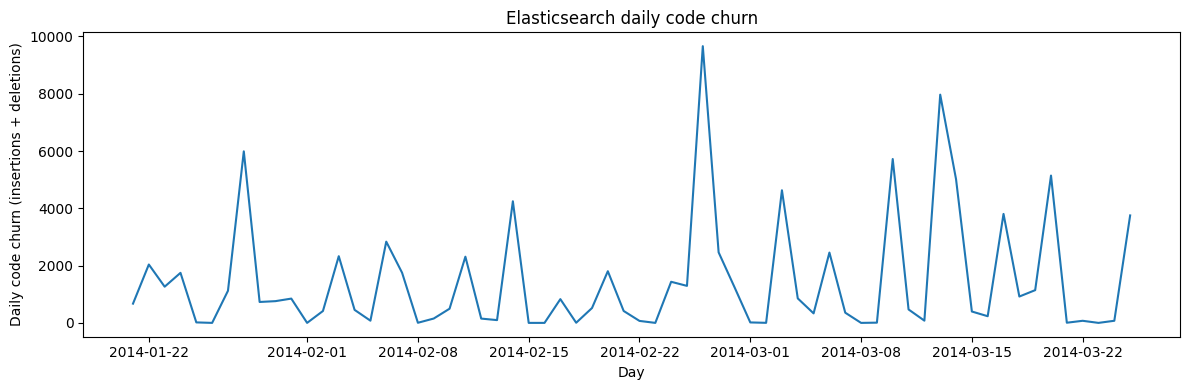

Top 2 churn outlier days:
2014-02-26    9661.0
2014-03-13    7968.0
Name: churn, dtype: float64

OUTLIER DAY: 2014-02-26
total churn: 9661
number of commits: 16

commit: e0684a112f0266bc57a815cb2494b6bc33b3e70d
insertions: 2219 | deletions: 1735 | churn: 3954
number of files touched: 72
files (first 25):
  src/main/java/org/elasticsearch/action/admin/indices/cache/clear/TransportClearIndicesCacheAction.java
  src/main/java/org/elasticsearch/cache/recycler/PageCacheRecycler.java
  src/main/java/org/elasticsearch/common/util/AbstractBigArray.java
  src/main/java/org/elasticsearch/common/util/BigArrays.java
  src/main/java/org/elasticsearch/common/util/BigFloatArray.java
  src/main/java/org/elasticsearch/common/util/FloatArray.java
  src/main/java/org/elasticsearch/index/cache/IndexCache.java
  src/main/java/org/elasticsearch/index/cache/IndexCacheModule.java
  src/main/java/org/elasticsearch/index/cache/id/IdCache.java
  src/main/java/org/elasticsearch/index/cache/id/IdCacheModule.java
 

In [6]:
import pandas as pd

#we collect commit level churn information
rows = []
commit_range = f"{from_tag}..{to_tag}"
commits = list(repo.iter_commits(commit_range))

for c in commits:
    day = pd.to_datetime(c.committed_datetime.date())
    insertions = c.stats.total.get("insertions", 0)
    deletions = c.stats.total.get("deletions", 0)
    churn = insertions + deletions

    rows.append({
        "day": day,
        "hash": c.hexsha,
        "insertions": insertions,
        "deletions": deletions,
        "churn": churn
    })

commit_df = pd.DataFrame(rows)

#we aggregate churn per day
daily_churn = commit_df.groupby("day")["churn"].sum().sort_index()

#we create a full daily timeline and fill missing days with 0 churn
#we choose this interpolation because churn is defined by commits.
#no commits on a day means no recorded code change
full_days = pd.date_range(daily_churn.index.min(), daily_churn.index.max(), freq="D")
daily_churn = daily_churn.reindex(full_days).fillna(0)

#we visualize the daily churn trend
plt.figure(figsize=(12, 4))
plt.plot(daily_churn.index, daily_churn.values)
plt.xlabel("Day")
plt.ylabel("Daily code churn (insertions + deletions)")
plt.title("Elasticsearch daily code churn")
plt.tight_layout()
plt.show()

#we identify the two largest churn outliers
outlier_days = daily_churn.sort_values(ascending=False).head(2)
print("Top 2 churn outlier days:")
print(outlier_days)
print()

#we analyze each outlier day in detail
for day in outlier_days.index:
    day_date = day.date()
    day_commits = commit_df[commit_df["day"].dt.date == day_date].copy()
    day_commits = day_commits.sort_values("churn", ascending=False)

    print("=" * 90)
    print("OUTLIER DAY:", day_date)
    print("total churn:", int(daily_churn.loc[day]))
    print("number of commits:", len(day_commits))
    print()

    for _, row in day_commits.iterrows():
        h = row["hash"]
        print("commit:", h)
        print(
            "insertions:", int(row["insertions"]),
            "| deletions:", int(row["deletions"]),
            "| churn:", int(row["churn"])
        )

        c = repo.commit(h)
        files = list(c.stats.files.keys())

        print("number of files touched:", len(files))
        print("files (first 25):")
        for f in files[:25]:
            print(" ", f)
        if len(files) > 25:
            print("  ...")

        #we show a truncated diff to keep output readable
        print("\nDIFF (truncated):")
        diff_text = repo.git.show(h)
        diff_lines = diff_text.splitlines()
        print("\n".join(diff_lines[:120]))
        if len(diff_lines) > 120:
            print("... (diff truncated)")
        print()


### Outlier analysis: is it a false positive or a reason for concern?

- **Outlier at 2014-02-26:** 

The strongest outlier happens at 2014-02-26, with a daily churn of 9,661 lines. It clearly stands out from the surrounding days in the churn trend. At first glance, this spike might suggest a risky or problematic change. However, if we look closely we can see that this outlier is not a reason for concern.

First, the churn on this day is caused by multiple commits (16 commits) rather than a single unusually large commit. This indicates a coordinated development activity rather than an uncontrolled or accidental change.

Second, the largest contributing commit touches a large number of files (72 files), spread across several core packages such as common.util, cache, and index.cache. This pattern is typical of a systematic refactoring or architectural change, and not a localized bug fix or a rushed feature addition.

Looking at the file names and packages involved, the changes appear to be related to memory management and internal infrastructure. These components are central to Elasticsearch’s performance and often require broad updates to maintain consistency and efficiency.

Finally, the churn consists of both insertions and deletions in comparable magnitude, which is a characteristic of a refactor rather than an uncontrolled code growth.

Conclusion:
This outlier should be considered a false positive in terms of risk detection. Although the churn is high, the changes are distributed across many files, occur in multiple commits, and are consistent with a deliberate and coordinated refactoring. So, it indicate healthy maintenance activity rather than a problematic development event.

- **Outlier at 2014-03-13**

The second outlier happens on 2014-03-13, with a total churn of 7,968 lines. Like the previous outlier, this spike is not caused by a single massive commit, but by multiple commits (18 commits) aggregated on the same day. That already suggests this is a “busy development day” rather than an isolated suspicious event.

When looking at some of the biggest contributing commits, the reason for the churn becomes clear:
    One commit introduces the "Context Suggester feature", where the diff shows a large amount of new documentation. Another commit introduces a "Cardinality aggregation feature". The addition of this features is planned, therefore, this outlier is also a false positive of risk detection.

### Interpolation justification: 
Days without commits are filled with 0 churn. Since churn is defined as changes introduced by commits, no commits implies no recorded churn for that day.